In [224]:
import pandas as pd
from finvizfinance.screener.overview import Overview
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [225]:
criteria = Overview()

In [226]:
# Criteria Set from CANSLIM method
filters_dic = {'Price':'Over $5', 'EPS growthqtr over qtr':'Over 20%', 'EPS growthpast 5 years':'Over 15%', 'InstitutionalOwnership':'Under 90%', 
               'Return on Equity':'Over +15%', '52-Week High/Low':'0-10% below High', 'Shares Outstanding': 'Under 50M', 'Price': 'Over $5', 'Average Volume': 'Over 100K'}

In [227]:
criteria.set_filter(filters_dict=filters_dic)

In [228]:
screened_stocks_df = criteria.screener_view()

In [229]:
screened_stocks_df

,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
0,CLFD,"Clearfield, Inc.",Technology,Communication Equipment,USA,1.130000e+09,40.36,96.45,-0.0213,475758.0
1,CVLG,"Covenant Logistics Group, Inc.",Industrials,Trucking,USA,5.363900e+08,6.96,33.97,0.0149,189847.0
2,GLP,Global Partners LP,Energy,Oil & Gas Midstream,USA,9.370100e+08,12.37,28.13,0.0126,94035.0
3,MGPI,"MGP Ingredients, Inc.",Consumer Defensive,Packaged Foods,USA,2.330000e+09,21.05,106.32,0.0108,109012.0
4,MUSA,Murphy USA Inc.,Consumer Cyclical,Specialty Retail,USA,6.260000e+09,13.10,285.73,0.0048,417013.0
5,OTTR,Otter Tail Corporation,Utilities,Utilities - Diversified,USA,2.840000e+09,13.56,70.76,0.0070,221415.0
6,SRTS,"Sensus Healthcare, Inc.",Healthcare,Medical Devices,USA,1.725400e+08,8.50,10.92,-0.0302,186991.0
7,USAK,"USA Truck, Inc.",Industrials,Trucking,USA,2.804400e+08,8.18,31.16,-0.0006,142579.0


In [230]:
tickers = list(screened_stocks_df.Ticker)
tickers

['CLFD', 'CVLG', 'GLP', 'MGPI', 'MUSA', 'OTTR', 'SRTS', 'USAK']

In [231]:
yf_data = yf.download(tickers, '2021-01-01','2022-07-30')

[*********************100%***********************]  8 of 8 completed


In [232]:
df_close = yf_data["Close"]
df_close.head()

,CLFD,CVLG,GLP,MGPI,MUSA,OTTR,SRTS,USAK
Date,,,,,,,,
2021-01-04,24.190001,14.36,16.900000,46.689999,128.199997,41.720001,3.86,8.69
2021-01-05,24.320000,14.91,17.160000,48.560001,127.139999,41.490002,4.36,8.87
2021-01-06,25.480000,15.60,17.280001,49.389999,130.679993,43.580002,4.31,9.04
2021-01-07,25.830000,15.73,17.100000,49.000000,129.500000,42.919998,4.40,9.40
2021-01-08,25.879999,15.77,16.980000,49.070000,127.379997,42.669998,4.18,9.68


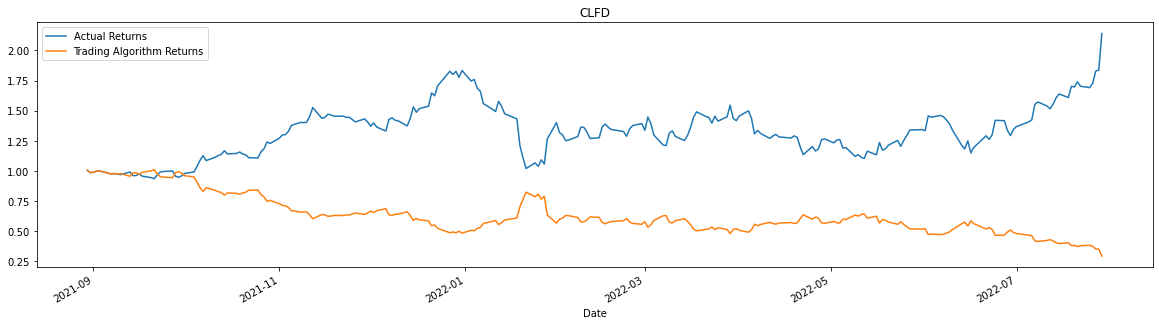

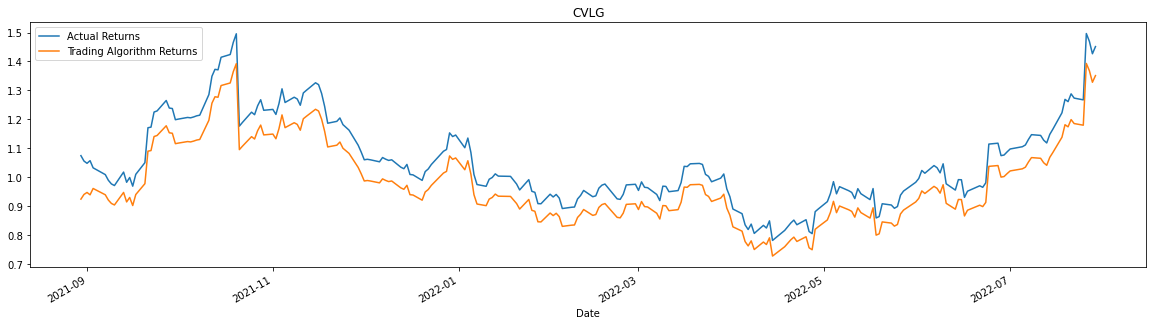

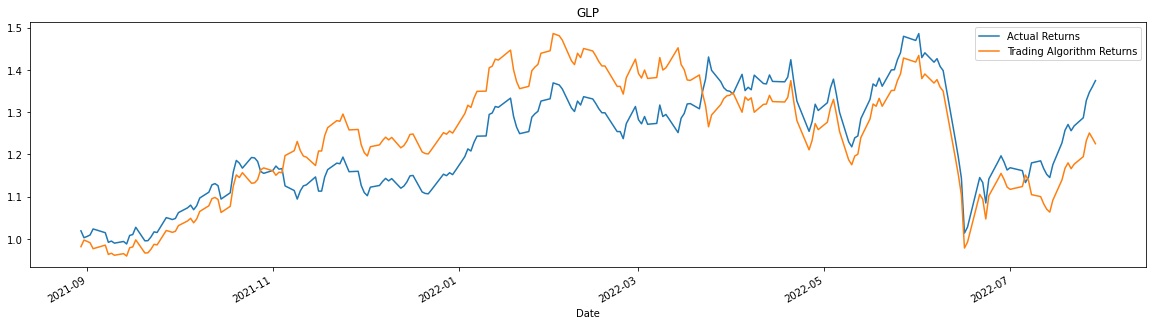

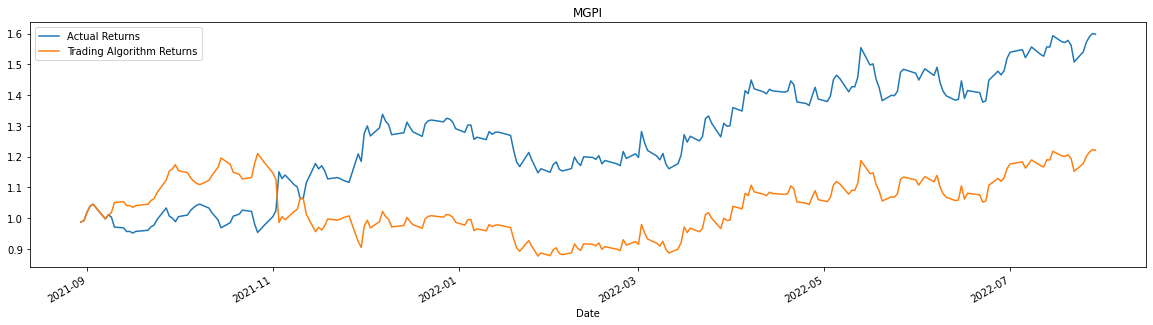

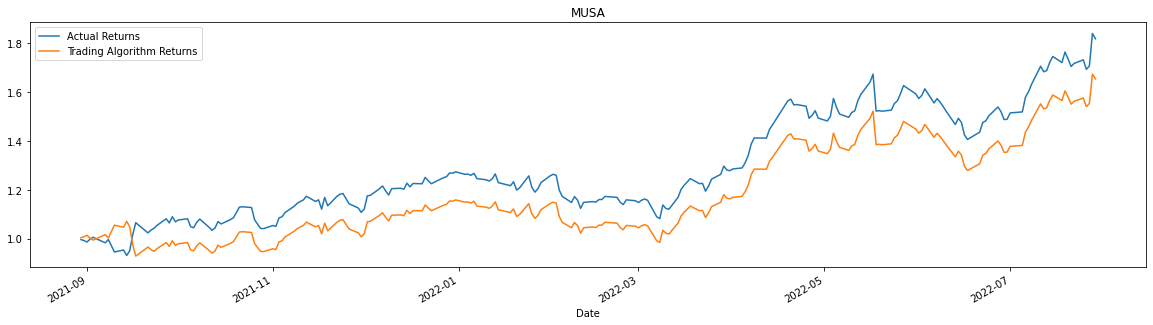

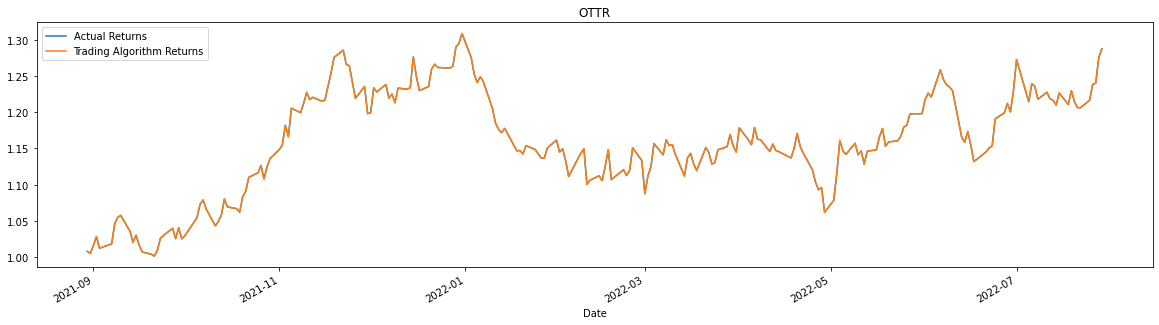

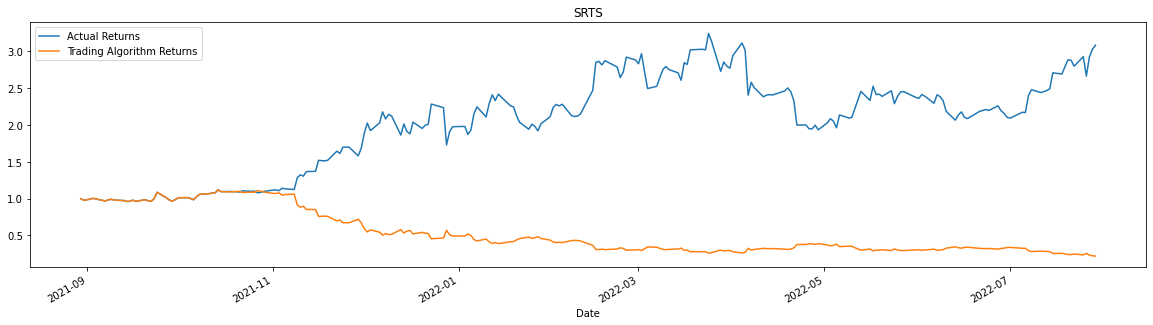

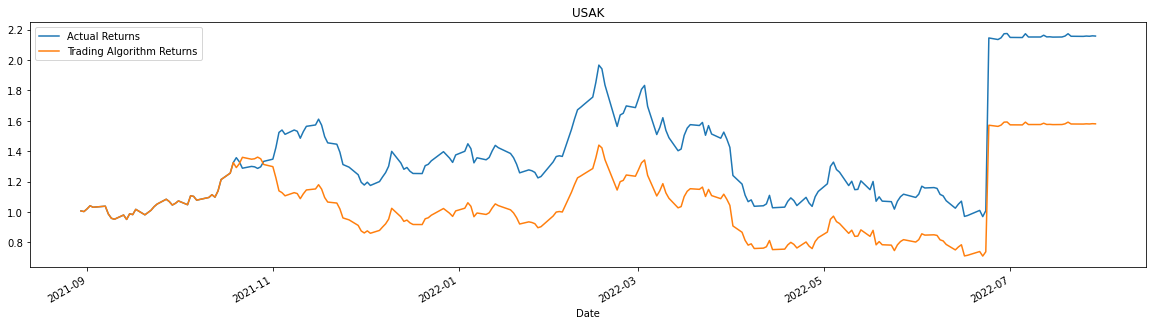

In [237]:
short_window = 25
long_window = 100

classification_report_dic = {}
testing_report_dic = {}
predictions_df_dic = {}

for symbol in tickers:
    df_close = pd.DataFrame(yf_data["Close"][symbol])
    df_close["Actual Returns"] = df_close[symbol].pct_change()
    df_close = df_close.dropna()
    df_close["sma_fast"] = df_close[symbol].rolling(window=short_window).mean()
    df_close["sma_slow"] = df_close[symbol].rolling(window=long_window).mean()
    df_close = df_close.dropna()
    X = df_close[['sma_fast', 'sma_slow']].shift().dropna().copy()
    df_close["Signal"] = 0.0
    
    # Create the signal to buy
    df_close.loc[(df_close["Actual Returns"] >= 0), "Signal"] = 1

    # Create the signal to sell
    df_close.loc[(df_close["Actual Returns"] < 0), "Signal"] = -1
    
    # Create training datasets

    y = df_close["Signal"].copy()
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=3)
    
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Create testing datasets

    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]
    # Standerdize the data

    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create classification report

    svm_model = svm.SVC()
    svm_model = svm_model.fit(X_train_scaled, y_train)

    training_signal_predictions = svm_model.predict(X_train_scaled)
    training_report = classification_report(y_train, training_signal_predictions, output_dict=True)
    classification_report_dic[symbol] = pd.DataFrame(training_report)
    
    # Backtest the machine learning algorithm
    
    testing_signal_predictions = svm_model.predict(X_test_scaled)
    testing_report = classification_report(y_test, testing_signal_predictions, output_dict=True)
    testing_report_dic[symbol] = pd.DataFrame(testing_report)
    
    # Compare actual and predicted returns

    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df["Predicted Signal"] = testing_signal_predictions
    predictions_df["Actual Returns"] = df_close["Actual Returns"]
    predictions_df["Trading Algorithm Returns"] = (
        df_close["Actual Returns"] * predictions_df["Predicted Signal"]
    )

    predictions_df_dic[symbol] = pd.DataFrame(predictions_df).head()
    
    (1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot(title=symbol, figsize = (20,5))

In [234]:
classification_report_dic

{'CLFD':                 -1.0        1.0  accuracy  macro avg  weighted avg
 precision   0.568966   0.833333   0.59375   0.701149      0.692888
 recall      0.970588   0.166667   0.59375   0.568627      0.593750
 f1-score    0.717391   0.277778   0.59375   0.497585      0.511322
 support    34.000000  30.000000   0.59375  64.000000     64.000000,
 'CVLG':                 -1.0        1.0  accuracy  macro avg  weighted avg
 precision   0.560000   0.512821   0.53125   0.536410      0.537147
 recall      0.424242   0.645161   0.53125   0.534702      0.531250
 f1-score    0.482759   0.571429   0.53125   0.527094      0.525708
 support    33.000000  31.000000   0.53125  64.000000     64.000000,
 'GLP':                 -1.0        1.0  accuracy  macro avg  weighted avg
 precision   0.555556   0.581818  0.578125   0.568687      0.570328
 recall      0.178571   0.888889  0.578125   0.533730      0.578125
 f1-score    0.270270   0.703297  0.578125   0.486783      0.513848
 support    28.000000  

In [235]:
testing_report_dic

{'CLFD':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    0.470852    0.625000   0.47619    0.547926      0.552931
 recall       0.972222    0.040650   0.47619    0.506436      0.476190
 f1-score     0.634441    0.076336   0.47619    0.355388      0.337268
 support    108.000000  123.000000   0.47619  231.000000    231.000000,
 'CVLG':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    0.600000    0.526549  0.528139    0.563274      0.561525
 recall       0.027273    0.983471  0.528139    0.505372      0.528139
 f1-score     0.052174    0.685879  0.528139    0.369026      0.384115
 support    110.000000  121.000000  0.528139  231.000000    231.000000,
 'GLP':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    0.490909    0.573864  0.554113    0.532386      0.537234
 recall       0.264706    0.782946  0.554113    0.523826      0.554113
 f1-score     0.343949    0.662295  0.554113    0.50

In [236]:
predictions_df_dic

{'CLFD':             Predicted Signal  Actual Returns  Trading Algorithm Returns
 Date                                                                   
 2021-08-30               1.0        0.004344                   0.004344
 2021-08-31               1.0       -0.020112                  -0.020112
 2021-09-01               1.0        0.004414                   0.004414
 2021-09-02               1.0        0.008130                   0.008130
 2021-09-03               1.0        0.002398                   0.002398,
 'CVLG':             Predicted Signal  Actual Returns  Trading Algorithm Returns
 Date                                                                   
 2021-08-30              -1.0        0.075022                  -0.075022
 2021-08-31              -1.0       -0.017346                   0.017346
 2021-09-01              -1.0       -0.007389                   0.007389
 2021-09-02              -1.0        0.008685                  -0.008685
 2021-09-03              -1.0     